## Configuración del entorno

In [ ]:
from fastai.vision.all import *
from pathlib import Path
import pandas as pd
from fastai.vision.all import *
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from random import shuffle, choices
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import os
import re
from torchvision import transforms
import torch
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
path = Path('/content/drive/MyDrive/VIU/TFM/data/pneumothorax/png_masks')

In [ ]:
from pathlib import Path
from PIL import Image
import numpy as np

mask_path = Path('/content/drive/MyDrive/VIU/TFM/data/pneumothorax/png_masks')

left_images = []
right_images = []

# Filtrar solo las imágenes que terminan con "_1_.png"
mask_files = [f for f in mask_path.glob("*_1_.png")]

for mask_file in mask_files:
    mask = Image.open(mask_file).convert("L")
    mask_array = np.array(mask)

    coords = np.argwhere(mask_array > 0)

    if coords.size > 0:
        _, x = coords[0]  # Tomamos la primera coordenada activada
        width = mask_array.shape[1]

        if x < width // 2:
            left_images.append(mask_file.name)
        else:
            right_images.append(mask_file.name)

print(f"Imágenes lado izquierdo: {len(left_images)}")
print(f"Imágenes lado derecho: {len(right_images)}")
print(f"Total analizadas: {len(mask_files)}")

Imágenes lado izquierdo: 1579
Imágenes lado derecho: 1090
Total analizadas: 2669


Máscaras con neumotórax en lado izquierdo: 1579

Máscaras con neumotórax en lado derecho: 1090

Total analizadas: 2669

In [ ]:
# Guardar las listas en archivos separados
with open("left_images.txt", "w") as f:
    for item in left_images:
        f.write(f"{item}\n")

with open("right_images.txt", "w") as f:
    for item in right_images:
        f.write(f"{item}\n")

In [ ]:
import json

data = {
    "left": left_images,
    "right": right_images
}

with open("images_sides.json", "w") as f:
    json.dump(data, f)

In [ ]:
import json

with open("images_sides.json", "r") as f:
    data = json.load(f)

left_images = data["left"]
right_images = data["right"]

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=5bb590fdd7d508a23636df5b3c10525d7e51e008a46d0bb90f7050218dbf0b22
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd

# Rutas
img_dir = Path('/content/drive/MyDrive/VIU/TFM/data/pneumothorax/png_images')
mask_dir = Path('/content/drive/MyDrive/VIU/TFM/data/pneumothorax/png_masks')

# Obtener imágenes de test con etiqueta positiva
image_files = [f for f in img_dir.iterdir() if "_test_1_" in f.name]

# Métricas
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

def compute_dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    return 2 * intersection / (mask1.sum() + mask2.sum()) if (mask1.sum() + mask2.sum()) != 0 else 0

In [ ]:
left_images = [img for img in left_images if "test" in img]

In [ ]:
right_images = [img for img in right_images if "test" in img]

In [ ]:
left_image_paths = [img_dir / fname for fname in left_images]
right_image_paths = [img_dir / fname for fname in right_images]

In [ ]:
learn = load_learner('/content/drive/MyDrive/VIU/TFM/modelos/resnet50/modelo_resnet50_12epochs.pkl')

/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
learn.model.to(device)
model = learn.model
model.eval()
last_conv_layer = model[0][-1][-1].conv3 # Este bloque contiene todas las capas finales convolucionales
model = learn.model
layers = [last_conv_layer]

In [ ]:
pred = 1
print("pred", pred)

target_class = ClassifierOutputTarget(pred)
classes = [target_class]

pred 1


In [ ]:
def method_metrics(camClass, image_files, cam_returns_heatmap=False,
                   target_layers=layers, target_class=ClassifierOutputTarget(pred)):
  # Resultados por imagen
  results = []

  # Iterar sobre las imágenes filtradas
  for img_path in image_files:
      print(f"Procesando: {img_path.name}")

      # Cargar imagen y máscara
      original_img = Image.open(img_path).convert("RGB")
      mask_path = mask_dir / img_path.name
      mask_img = Image.open(mask_path).convert("L")

      # Predicción
      pred_class, _, _ = learn.predict(img_path)
      pred = int(pred_class)
      if pred != 1:
          continue

      dl = learn.dls.test_dl([img_path])
      input_tensor = dl.one_batch()[0]

      cam = camClass(model=model, target_layers=target_layers)

      # Generar heatmap
      heatmap = cam(input_tensor=input_tensor, targets=[target_class])
      if cam_returns_heatmap == False:
        heatmap = heatmap[0]
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

      # Preparar ground truth
      gt_mask = (np.array(mask_img) > 0).astype(np.uint8)
      heatmap_resized = resize(heatmap, gt_mask.shape, preserve_range=True)

      # Thresholds
      thresholds = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]

      metrics = {"image": img_path.name}

      for t in thresholds:
          binary_heatmap = (heatmap_resized >= t).astype(np.uint8)
          iou = compute_iou(binary_heatmap, gt_mask)
          dice = compute_dice(binary_heatmap, gt_mask)

          metrics[f"iou_t{t}"] = iou
          metrics[f"dice_t{t}"] = dice

      results.append(metrics)
      del heatmap, heatmap_resized, binary_heatmap, gt_mask

      # 💡 Liberar memoria
      try:
          del cam, heatmap, heatmap_resized, binary_heatmap, gt_mask, input_tensor
      except NameError:
          pass

  return results

In [ ]:
def compute_metrics(df, thresholds):
    iou_means, iou_stds, dice_means, dice_stds = [], [], [], []
    for t in thresholds:
        iou_col = f"iou_t{t}"
        dice_col = f"dice_t{t}"

        iou_means.append(df[iou_col].mean())
        iou_stds.append(df[iou_col].std())

        dice_means.append(df[dice_col].mean())
        dice_stds.append(df[dice_col].std())

    return iou_means, iou_stds, dice_means, dice_stds

## Aciertos por lado

In [ ]:
from fastai.learner import load_learner

learn = load_learner('/content/drive/MyDrive/VIU/TFM/modelos/resnet50/modelo_resnet50_12epochs.pkl')

def count_correct_predictions(image_paths, model, positive_label=1):
    total = len(image_paths)
    correct = 0

    for f in image_paths:
        pred_class, _, _ = model.predict(f)
        if int(pred_class) == positive_label:
            correct += 1

    return correct, total

left_correct, left_total = count_correct_predictions(left_image_paths, learn)
right_correct, right_total = count_correct_predictions(right_image_paths, learn)

print(f"Lado izquierdo: {left_correct}/{left_total} ({left_correct/left_total*100:.2f}%)")
print(f"Lado derecho: {right_correct}/{right_total} ({right_correct/right_total*100:.2f}%)")

Lado izquierdo: 128/182 (70.33%)
Lado derecho: 76/108 (70.37%)


## GradCAM

In [ ]:
results_left = method_metrics(GradCAM, left_image_paths)
results_right = method_metrics(GradCAM, right_image_paths)

# Guardar resultados
import pandas as pd
df_left = pd.DataFrame(results_left)
df_right = pd.DataFrame(results_right)

df_left.to_csv("metricas_GRAD-CAM_izquierdo.csv", index=False)
df_right.to_csv("metricas_GRAD-CAM_derecho.csv", index=False)

print("✅ Métricas guardadas por lado.")


Procesando: 939_test_1_.png


Procesando: 914_test_1_.png


Procesando: 928_test_1_.png


Procesando: 938_test_1_.png


Procesando: 982_test_1_.png


Procesando: 883_test_1_.png


Procesando: 958_test_1_.png


Procesando: 957_test_1_.png


Procesando: 972_test_1_.png


Procesando: 877_test_1_.png


Procesando: 889_test_1_.png


Procesando: 949_test_1_.png


Procesando: 89_test_1_.png


Procesando: 878_test_1_.png


Procesando: 908_test_1_.png


Procesando: 90_test_1_.png


Procesando: 891_test_1_.png


Procesando: 896_test_1_.png


Procesando: 977_test_1_.png


Procesando: 86_test_1_.png


Procesando: 783_test_1_.png


Procesando: 667_test_1_.png


Procesando: 763_test_1_.png


Procesando: 943_test_1_.png


Procesando: 924_test_1_.png


Procesando: 99_test_1_.png


Procesando: 94_test_1_.png


Procesando: 913_test_1_.png


Procesando: 634_test_1_.png


Procesando: 718_test_1_.png


Procesando: 512_test_1_.png


Procesando: 469_test_1_.png


Procesando: 623_test_1_.png


Procesando: 780_test_1_.png


Procesando: 476_test_1_.png


Procesando: 813_test_1_.png


Procesando: 605_test_1_.png


Procesando: 452_test_1_.png


Procesando: 759_test_1_.png


Procesando: 595_test_1_.png


Procesando: 661_test_1_.png


Procesando: 6_test_1_.png


Procesando: 570_test_1_.png


Procesando: 47_test_1_.png


Procesando: 446_test_1_.png


Procesando: 80_test_1_.png


Procesando: 866_test_1_.png


Procesando: 654_test_1_.png


Procesando: 449_test_1_.png


Procesando: 831_test_1_.png


Procesando: 756_test_1_.png


Procesando: 558_test_1_.png


Procesando: 823_test_1_.png


Procesando: 717_test_1_.png


Procesando: 492_test_1_.png


Procesando: 631_test_1_.png


Procesando: 506_test_1_.png


Procesando: 448_test_1_.png


Procesando: 710_test_1_.png


Procesando: 557_test_1_.png


Procesando: 500_test_1_.png


Procesando: 445_test_1_.png


Procesando: 826_test_1_.png


Procesando: 663_test_1_.png


Procesando: 665_test_1_.png


Procesando: 732_test_1_.png


Procesando: 509_test_1_.png


Procesando: 483_test_1_.png


Procesando: 641_test_1_.png


Procesando: 740_test_1_.png


Procesando: 821_test_1_.png


Procesando: 74_test_1_.png


Procesando: 441_test_1_.png


Procesando: 703_test_1_.png


Procesando: 670_test_1_.png


Procesando: 518_test_1_.png


Procesando: 687_test_1_.png


Procesando: 526_test_1_.png


Procesando: 588_test_1_.png


Procesando: 653_test_1_.png


Procesando: 64_test_1_.png


Procesando: 437_test_1_.png


Procesando: 572_test_1_.png


Procesando: 498_test_1_.png


Procesando: 671_test_1_.png


Procesando: 758_test_1_.png


Procesando: 694_test_1_.png


Procesando: 776_test_1_.png


Procesando: 737_test_1_.png


Procesando: 77_test_1_.png


Procesando: 1254_test_1_.png


Procesando: 181_test_1_.png


Procesando: 1205_test_1_.png


Procesando: 301_test_1_.png


Procesando: 1194_test_1_.png


Procesando: 1348_test_1_.png


Procesando: 315_test_1_.png


Procesando: 205_test_1_.png


Procesando: 263_test_1_.png


Procesando: 153_test_1_.png


Procesando: 364_test_1_.png


Procesando: 426_test_1_.png


Procesando: 341_test_1_.png


Procesando: 1298_test_1_.png


Procesando: 1293_test_1_.png


Procesando: 316_test_1_.png


Procesando: 1312_test_1_.png


Procesando: 19_test_1_.png


Procesando: 1102_test_1_.png


Procesando: 1315_test_1_.png


Procesando: 152_test_1_.png


Procesando: 340_test_1_.png


Procesando: 1212_test_1_.png


Procesando: 284_test_1_.png


Procesando: 291_test_1_.png


Procesando: 1319_test_1_.png


Procesando: 129_test_1_.png


Procesando: 1151_test_1_.png


Procesando: 1290_test_1_.png


Procesando: 376_test_1_.png


Procesando: 218_test_1_.png


Procesando: 1335_test_1_.png


Procesando: 1192_test_1_.png


Procesando: 1069_test_1_.png


Procesando: 1314_test_1_.png


Procesando: 1327_test_1_.png


Procesando: 1132_test_1_.png


Procesando: 1105_test_1_.png


Procesando: 1247_test_1_.png


Procesando: 406_test_1_.png


Procesando: 1220_test_1_.png


Procesando: 325_test_1_.png


Procesando: 1062_test_1_.png


Procesando: 1077_test_1_.png


Procesando: 1368_test_1_.png


Procesando: 1120_test_1_.png


Procesando: 17_test_1_.png


Procesando: 250_test_1_.png


Procesando: 1209_test_1_.png


Procesando: 1195_test_1_.png


Procesando: 1225_test_1_.png


Procesando: 1337_test_1_.png


Procesando: 193_test_1_.png


Procesando: 242_test_1_.png


Procesando: 1349_test_1_.png


Procesando: 1086_test_1_.png


Procesando: 174_test_1_.png


Procesando: 42_test_1_.png


Procesando: 1332_test_1_.png


Procesando: 322_test_1_.png


Procesando: 336_test_1_.png


Procesando: 264_test_1_.png


Procesando: 147_test_1_.png


Procesando: 356_test_1_.png


Procesando: 1285_test_1_.png


Procesando: 1250_test_1_.png


Procesando: 392_test_1_.png


Procesando: 1325_test_1_.png


Procesando: 1226_test_1_.png


Procesando: 1264_test_1_.png


Procesando: 372_test_1_.png


Procesando: 217_test_1_.png


Procesando: 1145_test_1_.png


Procesando: 1329_test_1_.png


Procesando: 1317_test_1_.png


Procesando: 1027_test_1_.png


Procesando: 1014_test_1_.png


Procesando: 1007_test_1_.png


Procesando: 1029_test_1_.png


Procesando: 1040_test_1_.png


Procesando: 145_test_1_.png


Procesando: 279_test_1_.png


Procesando: 1154_test_1_.png


Procesando: 1053_test_1_.png


Procesando: 366_test_1_.png


Procesando: 1359_test_1_.png


Procesando: 1240_test_1_.png


Procesando: 1278_test_1_.png


Procesando: 387_test_1_.png


Procesando: 206_test_1_.png


Procesando: 223_test_1_.png


Procesando: 432_test_1_.png


Procesando: 986_test_1_.png


Procesando: 990_test_1_.png


Procesando: 941_test_1_.png


Procesando: 985_test_1_.png


Procesando: 988_test_1_.png


Procesando: 920_test_1_.png


Procesando: 911_test_1_.png


Procesando: 886_test_1_.png


Procesando: 894_test_1_.png


Procesando: 893_test_1_.png


Procesando: 98_test_1_.png


Procesando: 553_test_1_.png


Procesando: 543_test_1_.png


Procesando: 705_test_1_.png


Procesando: 784_test_1_.png


Procesando: 942_test_1_.png


Procesando: 645_test_1_.png


Procesando: 726_test_1_.png


Procesando: 566_test_1_.png


Procesando: 76_test_1_.png


Procesando: 485_test_1_.png


Procesando: 834_test_1_.png


Procesando: 785_test_1_.png


Procesando: 814_test_1_.png


Procesando: 491_test_1_.png


Procesando: 745_test_1_.png


Procesando: 550_test_1_.png


Procesando: 722_test_1_.png


Procesando: 791_test_1_.png


Procesando: 630_test_1_.png


Procesando: 495_test_1_.png


Procesando: 552_test_1_.png


Procesando: 707_test_1_.png


Procesando: 858_test_1_.png


Procesando: 7_test_1_.png


Procesando: 656_test_1_.png


Procesando: 658_test_1_.png


Procesando: 693_test_1_.png


Procesando: 861_test_1_.png


Procesando: 520_test_1_.png


Procesando: 713_test_1_.png


Procesando: 852_test_1_.png


Procesando: 585_test_1_.png


Procesando: 598_test_1_.png


Procesando: 1084_test_1_.png


Procesando: 531_test_1_.png


Procesando: 846_test_1_.png


Procesando: 640_test_1_.png


Procesando: 1083_test_1_.png


Procesando: 1141_test_1_.png


Procesando: 385_test_1_.png


Procesando: 1122_test_1_.png


Procesando: 1160_test_1_.png


Procesando: 1109_test_1_.png


Procesando: 288_test_1_.png


Procesando: 204_test_1_.png


Procesando: 1244_test_1_.png


Procesando: 1249_test_1_.png


Procesando: 146_test_1_.png


Procesando: 111_test_1_.png


Procesando: 287_test_1_.png


Procesando: 1299_test_1_.png


Procesando: 418_test_1_.png


Procesando: 1326_test_1_.png


Procesando: 1092_test_1_.png


Procesando: 1354_test_1_.png


Procesando: 156_test_1_.png


Procesando: 324_test_1_.png


Procesando: 184_test_1_.png


Procesando: 1058_test_1_.png


Procesando: 1207_test_1_.png


Procesando: 1202_test_1_.png


Procesando: 168_test_1_.png


Procesando: 1178_test_1_.png


Procesando: 378_test_1_.png


Procesando: 1115_test_1_.png


Procesando: 415_test_1_.png


Procesando: 115_test_1_.png


Procesando: 290_test_1_.png


Procesando: 1221_test_1_.png


Procesando: 1307_test_1_.png


Procesando: 219_test_1_.png


Procesando: 1363_test_1_.png


Procesando: 25_test_1_.png


Procesando: 1103_test_1_.png


Procesando: 1057_test_1_.png


Procesando: 1059_test_1_.png


Procesando: 1356_test_1_.png


Procesando: 1054_test_1_.png


Procesando: 266_test_1_.png


Procesando: 435_test_1_.png


Procesando: 160_test_1_.png


Procesando: 37_test_1_.png


Procesando: 1246_test_1_.png


Procesando: 1044_test_1_.png


Procesando: 1035_test_1_.png


Procesando: 1042_test_1_.png


Procesando: 1031_test_1_.png


Procesando: 101_test_1_.png


Procesando: 337_test_1_.png


Procesando: 1071_test_1_.png


Procesando: 1291_test_1_.png


Procesando: 1294_test_1_.png


Procesando: 1090_test_1_.png


Procesando: 424_test_1_.png


Procesando: 1033_test_1_.png


Procesando: 0_test_1_.png


Procesando: 1010_test_1_.png


✅ Métricas guardadas por lado.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los CSV por lado
df_left = pd.read_csv("metricas_GRAD-CAM_izquierdo.csv")
df_right = pd.read_csv("metricas_GRAD-CAM_derecho.csv")

# Extraer los thresholds desde las columnas (asumimos que son iguales en ambos)
thresholds = sorted({float(col.split('_t')[1]) for col in df_left.columns if 'iou_t' in col})

In [ ]:
iou_left, iou_left_std, dice_left, dice_left_std = compute_metrics(df_left, thresholds)
iou_right, iou_right_std, dice_right, dice_right_std = compute_metrics(df_right, thresholds)

In [ ]:
def print_metrics_table(thresholds, iou_means, iou_stds, dice_means, dice_stds, title=""):
    print(f"\n===== {title} =====")
    print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
    print("-" * 60)
    for i, t in enumerate(thresholds):
        print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

# Mostrar resultados para lado izquierdo y derecho
print_metrics_table(thresholds, iou_left, iou_left_std, dice_left, dice_left_std, title="Lado Izquierdo")
print_metrics_table(thresholds, iou_right, iou_right_std, dice_right, dice_right_std, title="Lado Derecho")


===== Lado Izquierdo =====
Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0081     0.0197     0.0153       0.0359    
0.4        0.0054     0.0151     0.0104       0.0283    
0.5        0.0045     0.0132     0.0086       0.0249    
0.5        0.0037     0.0118     0.0072       0.0224    
0.6        0.0029     0.0099     0.0056       0.0190    
0.6        0.0023     0.0086     0.0044       0.0163    
0.7        0.0005     0.0023     0.0009       0.0046    
0.8        0.0001     0.0009     0.0001       0.0017    
0.9        0.0000     0.0004     0.0001       0.0007    

===== Lado Derecho =====
Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0038     0.0087     0.0075       0.0169    
0.4        0.0028     0.0082     0.0054       0.0158    
0.5        0.0022     0.0074     0.0042       0.0143    
0.5        0.0016     0.00

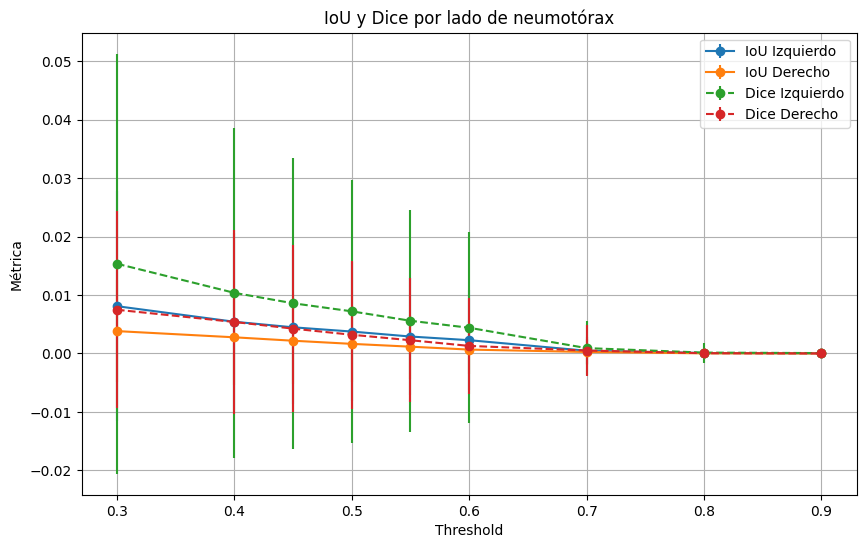

In [ ]:
plt.figure(figsize=(10, 6))

# IoU por lado
plt.errorbar(thresholds, iou_left, yerr=iou_left_std, fmt='-o', label='IoU Izquierdo')
plt.errorbar(thresholds, iou_right, yerr=iou_right_std, fmt='-o', label='IoU Derecho')

# Dice por lado
plt.errorbar(thresholds, dice_left, yerr=dice_left_std, fmt='--o', label='Dice Izquierdo')
plt.errorbar(thresholds, dice_right, yerr=dice_right_std, fmt='--o', label='Dice Derecho')

plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.title('IoU y Dice por lado de neumotórax')
plt.legend()
plt.grid(True)
plt.show()

## GradCAM++

In [ ]:
results_left = method_metrics(GradCAMPlusPlus, left_image_paths)
results_right = method_metrics(GradCAMPlusPlus, right_image_paths)

# Guardar resultados
import pandas as pd
df_left = pd.DataFrame(results_left)
df_right = pd.DataFrame(results_right)

df_left.to_csv("metricas_GRAD-CAM++_izquierdo.csv", index=False)
df_right.to_csv("metricas_GRAD-CAM++_derecho.csv", index=False)

print("✅ Métricas guardadas por lado.")

Procesando: 939_test_1_.png


Procesando: 914_test_1_.png


Procesando: 928_test_1_.png


Procesando: 938_test_1_.png


Procesando: 982_test_1_.png


Procesando: 883_test_1_.png


Procesando: 958_test_1_.png


Procesando: 957_test_1_.png


Procesando: 972_test_1_.png


Procesando: 877_test_1_.png


Procesando: 889_test_1_.png


Procesando: 949_test_1_.png


Procesando: 89_test_1_.png


Procesando: 878_test_1_.png


Procesando: 908_test_1_.png


Procesando: 90_test_1_.png


Procesando: 891_test_1_.png


Procesando: 896_test_1_.png


Procesando: 977_test_1_.png


Procesando: 86_test_1_.png


Procesando: 783_test_1_.png


Procesando: 667_test_1_.png


Procesando: 763_test_1_.png


Procesando: 943_test_1_.png


Procesando: 924_test_1_.png


Procesando: 99_test_1_.png


Procesando: 94_test_1_.png


Procesando: 913_test_1_.png


Procesando: 634_test_1_.png


Procesando: 718_test_1_.png


Procesando: 512_test_1_.png


Procesando: 469_test_1_.png


Procesando: 623_test_1_.png


Procesando: 780_test_1_.png


Procesando: 476_test_1_.png


Procesando: 813_test_1_.png


Procesando: 605_test_1_.png


Procesando: 452_test_1_.png


Procesando: 759_test_1_.png


Procesando: 595_test_1_.png


Procesando: 661_test_1_.png


Procesando: 6_test_1_.png


Procesando: 570_test_1_.png


Procesando: 47_test_1_.png


Procesando: 446_test_1_.png


Procesando: 80_test_1_.png


Procesando: 866_test_1_.png


Procesando: 654_test_1_.png


Procesando: 449_test_1_.png


Procesando: 831_test_1_.png


Procesando: 756_test_1_.png


Procesando: 558_test_1_.png


Procesando: 823_test_1_.png


Procesando: 717_test_1_.png


Procesando: 492_test_1_.png


Procesando: 631_test_1_.png


Procesando: 506_test_1_.png


Procesando: 448_test_1_.png


Procesando: 710_test_1_.png


Procesando: 557_test_1_.png


Procesando: 500_test_1_.png


Procesando: 445_test_1_.png


Procesando: 826_test_1_.png


Procesando: 663_test_1_.png


Procesando: 665_test_1_.png


Procesando: 732_test_1_.png


Procesando: 509_test_1_.png


Procesando: 483_test_1_.png


Procesando: 641_test_1_.png


Procesando: 740_test_1_.png


Procesando: 821_test_1_.png


Procesando: 74_test_1_.png


Procesando: 441_test_1_.png


Procesando: 703_test_1_.png


Procesando: 670_test_1_.png


Procesando: 518_test_1_.png


Procesando: 687_test_1_.png


Procesando: 526_test_1_.png


Procesando: 588_test_1_.png


Procesando: 653_test_1_.png


Procesando: 64_test_1_.png


Procesando: 437_test_1_.png


Procesando: 572_test_1_.png


Procesando: 498_test_1_.png


Procesando: 671_test_1_.png


Procesando: 758_test_1_.png


Procesando: 694_test_1_.png


Procesando: 776_test_1_.png


Procesando: 737_test_1_.png


Procesando: 77_test_1_.png


Procesando: 1254_test_1_.png


Procesando: 181_test_1_.png


Procesando: 1205_test_1_.png


Procesando: 301_test_1_.png


Procesando: 1194_test_1_.png


Procesando: 1348_test_1_.png


Procesando: 315_test_1_.png


Procesando: 205_test_1_.png


Procesando: 263_test_1_.png


Procesando: 153_test_1_.png


Procesando: 364_test_1_.png


Procesando: 426_test_1_.png


Procesando: 341_test_1_.png


Procesando: 1298_test_1_.png


Procesando: 1293_test_1_.png


Procesando: 316_test_1_.png


Procesando: 1312_test_1_.png


Procesando: 19_test_1_.png


Procesando: 1102_test_1_.png


Procesando: 1315_test_1_.png


Procesando: 152_test_1_.png


Procesando: 340_test_1_.png


Procesando: 1212_test_1_.png


Procesando: 284_test_1_.png


Procesando: 291_test_1_.png


Procesando: 1319_test_1_.png


Procesando: 129_test_1_.png


Procesando: 1151_test_1_.png


Procesando: 1290_test_1_.png


Procesando: 376_test_1_.png


Procesando: 218_test_1_.png


Procesando: 1335_test_1_.png


Procesando: 1192_test_1_.png


Procesando: 1069_test_1_.png


Procesando: 1314_test_1_.png


Procesando: 1327_test_1_.png


Procesando: 1132_test_1_.png


Procesando: 1105_test_1_.png


Procesando: 1247_test_1_.png


Procesando: 406_test_1_.png


Procesando: 1220_test_1_.png


Procesando: 325_test_1_.png


Procesando: 1062_test_1_.png


Procesando: 1077_test_1_.png


Procesando: 1368_test_1_.png


Procesando: 1120_test_1_.png


Procesando: 17_test_1_.png


Procesando: 250_test_1_.png


Procesando: 1209_test_1_.png


Procesando: 1195_test_1_.png


Procesando: 1225_test_1_.png


Procesando: 1337_test_1_.png


Procesando: 193_test_1_.png


Procesando: 242_test_1_.png


Procesando: 1349_test_1_.png


Procesando: 1086_test_1_.png


Procesando: 174_test_1_.png


Procesando: 42_test_1_.png


Procesando: 1332_test_1_.png


Procesando: 322_test_1_.png


Procesando: 336_test_1_.png


Procesando: 264_test_1_.png


Procesando: 147_test_1_.png


Procesando: 356_test_1_.png


Procesando: 1285_test_1_.png


Procesando: 1250_test_1_.png


Procesando: 392_test_1_.png


Procesando: 1325_test_1_.png


Procesando: 1226_test_1_.png


Procesando: 1264_test_1_.png


Procesando: 372_test_1_.png


Procesando: 217_test_1_.png


Procesando: 1145_test_1_.png


Procesando: 1329_test_1_.png


Procesando: 1317_test_1_.png


Procesando: 1027_test_1_.png


Procesando: 1014_test_1_.png


Procesando: 1007_test_1_.png


Procesando: 1029_test_1_.png


Procesando: 1040_test_1_.png


Procesando: 145_test_1_.png


Procesando: 279_test_1_.png


Procesando: 1154_test_1_.png


Procesando: 1053_test_1_.png


Procesando: 366_test_1_.png


Procesando: 1359_test_1_.png


Procesando: 1240_test_1_.png


Procesando: 1278_test_1_.png


Procesando: 387_test_1_.png


Procesando: 206_test_1_.png


Procesando: 223_test_1_.png


Procesando: 432_test_1_.png


Procesando: 986_test_1_.png


Procesando: 990_test_1_.png


Procesando: 941_test_1_.png


Procesando: 985_test_1_.png


Procesando: 988_test_1_.png


Procesando: 920_test_1_.png


Procesando: 911_test_1_.png


Procesando: 886_test_1_.png


Procesando: 894_test_1_.png


Procesando: 893_test_1_.png


Procesando: 98_test_1_.png


Procesando: 553_test_1_.png


Procesando: 543_test_1_.png


Procesando: 705_test_1_.png


Procesando: 784_test_1_.png


Procesando: 942_test_1_.png


Procesando: 645_test_1_.png


Procesando: 726_test_1_.png


Procesando: 566_test_1_.png


Procesando: 76_test_1_.png


Procesando: 485_test_1_.png


Procesando: 834_test_1_.png


Procesando: 785_test_1_.png


Procesando: 814_test_1_.png


Procesando: 491_test_1_.png


Procesando: 745_test_1_.png


Procesando: 550_test_1_.png


Procesando: 722_test_1_.png


Procesando: 791_test_1_.png


Procesando: 630_test_1_.png


Procesando: 495_test_1_.png


Procesando: 552_test_1_.png


Procesando: 707_test_1_.png


Procesando: 858_test_1_.png


Procesando: 7_test_1_.png


Procesando: 656_test_1_.png


Procesando: 658_test_1_.png


Procesando: 693_test_1_.png


Procesando: 861_test_1_.png


Procesando: 520_test_1_.png


/tmp/ipython-input-2188057230.py:30: RuntimeWarning: invalid value encountered in divide
  heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
/usr/local/lib/python3.12/dist-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/usr/local/lib/python3.12/dist-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


Procesando: 713_test_1_.png


Procesando: 852_test_1_.png


Procesando: 585_test_1_.png


Procesando: 598_test_1_.png


Procesando: 1084_test_1_.png


Procesando: 531_test_1_.png


Procesando: 846_test_1_.png


Procesando: 640_test_1_.png


Procesando: 1083_test_1_.png


Procesando: 1141_test_1_.png


Procesando: 385_test_1_.png


Procesando: 1122_test_1_.png


Procesando: 1160_test_1_.png


Procesando: 1109_test_1_.png


Procesando: 288_test_1_.png


Procesando: 204_test_1_.png


Procesando: 1244_test_1_.png


Procesando: 1249_test_1_.png


Procesando: 146_test_1_.png


Procesando: 111_test_1_.png


Procesando: 287_test_1_.png


Procesando: 1299_test_1_.png


Procesando: 418_test_1_.png


Procesando: 1326_test_1_.png


Procesando: 1092_test_1_.png


Procesando: 1354_test_1_.png


Procesando: 156_test_1_.png


Procesando: 324_test_1_.png


Procesando: 184_test_1_.png


Procesando: 1058_test_1_.png


Procesando: 1207_test_1_.png


Procesando: 1202_test_1_.png


Procesando: 168_test_1_.png


Procesando: 1178_test_1_.png


Procesando: 378_test_1_.png


Procesando: 1115_test_1_.png


Procesando: 415_test_1_.png


Procesando: 115_test_1_.png


Procesando: 290_test_1_.png


Procesando: 1221_test_1_.png


Procesando: 1307_test_1_.png


Procesando: 219_test_1_.png


Procesando: 1363_test_1_.png


Procesando: 25_test_1_.png


Procesando: 1103_test_1_.png


Procesando: 1057_test_1_.png


Procesando: 1059_test_1_.png


Procesando: 1356_test_1_.png


Procesando: 1054_test_1_.png


Procesando: 266_test_1_.png


Procesando: 435_test_1_.png


Procesando: 160_test_1_.png


Procesando: 37_test_1_.png


Procesando: 1246_test_1_.png


Procesando: 1044_test_1_.png


Procesando: 1035_test_1_.png


Procesando: 1042_test_1_.png


Procesando: 1031_test_1_.png


Procesando: 101_test_1_.png


Procesando: 337_test_1_.png


Procesando: 1071_test_1_.png


Procesando: 1291_test_1_.png


Procesando: 1294_test_1_.png


Procesando: 1090_test_1_.png


Procesando: 424_test_1_.png


Procesando: 1033_test_1_.png


Procesando: 0_test_1_.png


Procesando: 1010_test_1_.png


✅ Métricas guardadas por lado.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los CSV por lado
df_left = pd.read_csv("metricas_GRAD-CAM++_izquierdo.csv")
df_right = pd.read_csv("metricas_GRAD-CAM++_derecho.csv")

# Extraer los thresholds desde las columnas (asumimos que son iguales en ambos)
thresholds = sorted({float(col.split('_t')[1]) for col in df_left.columns if 'iou_t' in col})

In [ ]:
iou_left, iou_left_std, dice_left, dice_left_std = compute_metrics(df_left, thresholds)
iou_right, iou_right_std, dice_right, dice_right_std = compute_metrics(df_right, thresholds)

In [ ]:
def print_metrics_table(thresholds, iou_means, iou_stds, dice_means, dice_stds, title=""):
    print(f"\n===== {title} =====")
    print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
    print("-" * 60)
    for i, t in enumerate(thresholds):
        print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

# Mostrar resultados para lado izquierdo y derecho
print_metrics_table(thresholds, iou_left, iou_left_std, dice_left, dice_left_std, title="Lado Izquierdo")
print_metrics_table(thresholds, iou_right, iou_right_std, dice_right, dice_right_std, title="Lado Derecho")


===== Lado Izquierdo =====
Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0148     0.0277     0.0279       0.0491    
0.4        0.0125     0.0273     0.0234       0.0486    
0.5        0.0114     0.0266     0.0212       0.0474    
0.5        0.0099     0.0256     0.0185       0.0458    
0.6        0.0086     0.0242     0.0160       0.0434    
0.6        0.0071     0.0217     0.0133       0.0394    
0.7        0.0045     0.0172     0.0084       0.0316    
0.8        0.0026     0.0137     0.0048       0.0251    
0.9        0.0006     0.0042     0.0013       0.0082    

===== Lado Derecho =====
Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0171     0.0283     0.0321       0.0518    
0.4        0.0158     0.0293     0.0296       0.0533    
0.5        0.0146     0.0293     0.0274       0.0530    
0.5        0.0131     0.02

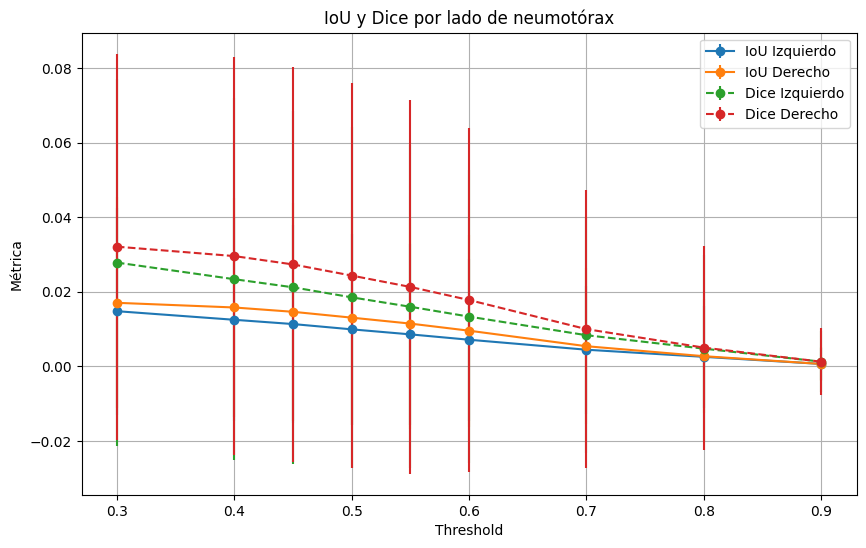

In [ ]:
plt.figure(figsize=(10, 6))

# IoU por lado
plt.errorbar(thresholds, iou_left, yerr=iou_left_std, fmt='-o', label='IoU Izquierdo')
plt.errorbar(thresholds, iou_right, yerr=iou_right_std, fmt='-o', label='IoU Derecho')

# Dice por lado
plt.errorbar(thresholds, dice_left, yerr=dice_left_std, fmt='--o', label='Dice Izquierdo')
plt.errorbar(thresholds, dice_right, yerr=dice_right_std, fmt='--o', label='Dice Derecho')

plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.title('IoU y Dice por lado de neumotórax')
plt.legend()
plt.grid(True)
plt.show()

## EigenCAM

In [ ]:
results_left = method_metrics(EigenCAM, left_image_paths)
results_right = method_metrics(EigenCAM, right_image_paths)

# Guardar resultados
import pandas as pd
df_left = pd.DataFrame(results_left)
df_right = pd.DataFrame(results_right)

df_left.to_csv("metricas_EigenCAM_izquierdo.csv", index=False)
df_right.to_csv("metricas_EigenCAM_derecho.csv", index=False)

print("✅ Métricas guardadas por lado.")

Procesando: 939_test_1_.png


Procesando: 914_test_1_.png


Procesando: 928_test_1_.png


Procesando: 938_test_1_.png


Procesando: 982_test_1_.png


Procesando: 883_test_1_.png


Procesando: 958_test_1_.png


Procesando: 957_test_1_.png


Procesando: 972_test_1_.png


Procesando: 877_test_1_.png


Procesando: 889_test_1_.png


Procesando: 949_test_1_.png


Procesando: 89_test_1_.png


Procesando: 878_test_1_.png


Procesando: 908_test_1_.png


Procesando: 90_test_1_.png


Procesando: 891_test_1_.png


Procesando: 896_test_1_.png


Procesando: 977_test_1_.png


Procesando: 86_test_1_.png


Procesando: 783_test_1_.png


Procesando: 667_test_1_.png


Procesando: 763_test_1_.png


Procesando: 943_test_1_.png


Procesando: 924_test_1_.png


Procesando: 99_test_1_.png


Procesando: 94_test_1_.png


Procesando: 913_test_1_.png


Procesando: 634_test_1_.png


Procesando: 718_test_1_.png


Procesando: 512_test_1_.png


Procesando: 469_test_1_.png


Procesando: 623_test_1_.png


Procesando: 780_test_1_.png


Procesando: 476_test_1_.png


Procesando: 813_test_1_.png


Procesando: 605_test_1_.png


Procesando: 452_test_1_.png


Procesando: 759_test_1_.png


Procesando: 595_test_1_.png


Procesando: 661_test_1_.png


Procesando: 6_test_1_.png


Procesando: 570_test_1_.png


Procesando: 47_test_1_.png


Procesando: 446_test_1_.png


Procesando: 80_test_1_.png


Procesando: 866_test_1_.png


Procesando: 654_test_1_.png


Procesando: 449_test_1_.png


Procesando: 831_test_1_.png


Procesando: 756_test_1_.png


Procesando: 558_test_1_.png


Procesando: 823_test_1_.png


Procesando: 717_test_1_.png


Procesando: 492_test_1_.png


Procesando: 631_test_1_.png


Procesando: 506_test_1_.png


Procesando: 448_test_1_.png


Procesando: 710_test_1_.png


Procesando: 557_test_1_.png


Procesando: 500_test_1_.png


Procesando: 445_test_1_.png


Procesando: 826_test_1_.png


Procesando: 663_test_1_.png


Procesando: 665_test_1_.png


Procesando: 732_test_1_.png


Procesando: 509_test_1_.png


Procesando: 483_test_1_.png


Procesando: 641_test_1_.png


Procesando: 740_test_1_.png


Procesando: 821_test_1_.png


Procesando: 74_test_1_.png


Procesando: 441_test_1_.png


Procesando: 703_test_1_.png


Procesando: 670_test_1_.png


Procesando: 518_test_1_.png


Procesando: 687_test_1_.png


Procesando: 526_test_1_.png


Procesando: 588_test_1_.png


Procesando: 653_test_1_.png


Procesando: 64_test_1_.png


Procesando: 437_test_1_.png


Procesando: 572_test_1_.png


Procesando: 498_test_1_.png


Procesando: 671_test_1_.png


Procesando: 758_test_1_.png


Procesando: 694_test_1_.png


Procesando: 776_test_1_.png


Procesando: 737_test_1_.png


Procesando: 77_test_1_.png


Procesando: 1254_test_1_.png


Procesando: 181_test_1_.png


Procesando: 1205_test_1_.png


Procesando: 301_test_1_.png


Procesando: 1194_test_1_.png


Procesando: 1348_test_1_.png


Procesando: 315_test_1_.png


Procesando: 205_test_1_.png


Procesando: 263_test_1_.png


Procesando: 153_test_1_.png


Procesando: 364_test_1_.png


Procesando: 426_test_1_.png


Procesando: 341_test_1_.png


Procesando: 1298_test_1_.png


Procesando: 1293_test_1_.png


Procesando: 316_test_1_.png


Procesando: 1312_test_1_.png


Procesando: 19_test_1_.png


Procesando: 1102_test_1_.png


Procesando: 1315_test_1_.png


Procesando: 152_test_1_.png


Procesando: 340_test_1_.png


Procesando: 1212_test_1_.png


Procesando: 284_test_1_.png


Procesando: 291_test_1_.png


Procesando: 1319_test_1_.png


Procesando: 129_test_1_.png


Procesando: 1151_test_1_.png


Procesando: 1290_test_1_.png


Procesando: 376_test_1_.png


Procesando: 218_test_1_.png


Procesando: 1335_test_1_.png


Procesando: 1192_test_1_.png


Procesando: 1069_test_1_.png


Procesando: 1314_test_1_.png


Procesando: 1327_test_1_.png


Procesando: 1132_test_1_.png


Procesando: 1105_test_1_.png


Procesando: 1247_test_1_.png


Procesando: 406_test_1_.png


Procesando: 1220_test_1_.png


Procesando: 325_test_1_.png


Procesando: 1062_test_1_.png


Procesando: 1077_test_1_.png


Procesando: 1368_test_1_.png


Procesando: 1120_test_1_.png


Procesando: 17_test_1_.png


Procesando: 250_test_1_.png


Procesando: 1209_test_1_.png


Procesando: 1195_test_1_.png


Procesando: 1225_test_1_.png


Procesando: 1337_test_1_.png


Procesando: 193_test_1_.png


Procesando: 242_test_1_.png


Procesando: 1349_test_1_.png


Procesando: 1086_test_1_.png


Procesando: 174_test_1_.png


Procesando: 42_test_1_.png


Procesando: 1332_test_1_.png


Procesando: 322_test_1_.png


Procesando: 336_test_1_.png


Procesando: 264_test_1_.png


Procesando: 147_test_1_.png


Procesando: 356_test_1_.png


Procesando: 1285_test_1_.png


Procesando: 1250_test_1_.png


Procesando: 392_test_1_.png


Procesando: 1325_test_1_.png


Procesando: 1226_test_1_.png


Procesando: 1264_test_1_.png


Procesando: 372_test_1_.png


Procesando: 217_test_1_.png


Procesando: 1145_test_1_.png


Procesando: 1329_test_1_.png


Procesando: 1317_test_1_.png


Procesando: 1027_test_1_.png


Procesando: 1014_test_1_.png


Procesando: 1007_test_1_.png


Procesando: 1029_test_1_.png


Procesando: 1040_test_1_.png


Procesando: 145_test_1_.png


Procesando: 279_test_1_.png


Procesando: 1154_test_1_.png


Procesando: 1053_test_1_.png


Procesando: 366_test_1_.png


Procesando: 1359_test_1_.png


Procesando: 1240_test_1_.png


Procesando: 1278_test_1_.png


Procesando: 387_test_1_.png


Procesando: 206_test_1_.png


Procesando: 223_test_1_.png


Procesando: 432_test_1_.png


Procesando: 986_test_1_.png


Procesando: 990_test_1_.png


Procesando: 941_test_1_.png


Procesando: 985_test_1_.png


Procesando: 988_test_1_.png


Procesando: 920_test_1_.png


Procesando: 911_test_1_.png


Procesando: 886_test_1_.png


Procesando: 894_test_1_.png


Procesando: 893_test_1_.png


Procesando: 98_test_1_.png


Procesando: 553_test_1_.png


Procesando: 543_test_1_.png


Procesando: 705_test_1_.png


Procesando: 784_test_1_.png


Procesando: 942_test_1_.png


Procesando: 645_test_1_.png


Procesando: 726_test_1_.png


Procesando: 566_test_1_.png


Procesando: 76_test_1_.png


Procesando: 485_test_1_.png


Procesando: 834_test_1_.png


Procesando: 785_test_1_.png


Procesando: 814_test_1_.png


Procesando: 491_test_1_.png


Procesando: 745_test_1_.png


Procesando: 550_test_1_.png


Procesando: 722_test_1_.png


Procesando: 791_test_1_.png


Procesando: 630_test_1_.png


Procesando: 495_test_1_.png


Procesando: 552_test_1_.png


Procesando: 707_test_1_.png


Procesando: 858_test_1_.png


Procesando: 7_test_1_.png


Procesando: 656_test_1_.png


Procesando: 658_test_1_.png


Procesando: 693_test_1_.png


Procesando: 861_test_1_.png


Procesando: 520_test_1_.png


Procesando: 713_test_1_.png


Procesando: 852_test_1_.png


Procesando: 585_test_1_.png


Procesando: 598_test_1_.png


Procesando: 1084_test_1_.png


Procesando: 531_test_1_.png


Procesando: 846_test_1_.png


Procesando: 640_test_1_.png


Procesando: 1083_test_1_.png


Procesando: 1141_test_1_.png


Procesando: 385_test_1_.png


Procesando: 1122_test_1_.png


Procesando: 1160_test_1_.png


Procesando: 1109_test_1_.png


Procesando: 288_test_1_.png


Procesando: 204_test_1_.png


Procesando: 1244_test_1_.png


Procesando: 1249_test_1_.png


Procesando: 146_test_1_.png


Procesando: 111_test_1_.png


Procesando: 287_test_1_.png


Procesando: 1299_test_1_.png


Procesando: 418_test_1_.png


Procesando: 1326_test_1_.png


Procesando: 1092_test_1_.png


Procesando: 1354_test_1_.png


Procesando: 156_test_1_.png


Procesando: 324_test_1_.png


Procesando: 184_test_1_.png


Procesando: 1058_test_1_.png


Procesando: 1207_test_1_.png


Procesando: 1202_test_1_.png


Procesando: 168_test_1_.png


Procesando: 1178_test_1_.png


Procesando: 378_test_1_.png


Procesando: 1115_test_1_.png


Procesando: 415_test_1_.png


Procesando: 115_test_1_.png


Procesando: 290_test_1_.png


Procesando: 1221_test_1_.png


Procesando: 1307_test_1_.png


Procesando: 219_test_1_.png


Procesando: 1363_test_1_.png


Procesando: 25_test_1_.png


Procesando: 1103_test_1_.png


Procesando: 1057_test_1_.png


Procesando: 1059_test_1_.png


Procesando: 1356_test_1_.png


Procesando: 1054_test_1_.png


Procesando: 266_test_1_.png


Procesando: 435_test_1_.png


Procesando: 160_test_1_.png


Procesando: 37_test_1_.png


Procesando: 1246_test_1_.png


Procesando: 1044_test_1_.png


Procesando: 1035_test_1_.png


Procesando: 1042_test_1_.png


Procesando: 1031_test_1_.png


Procesando: 101_test_1_.png


Procesando: 337_test_1_.png


Procesando: 1071_test_1_.png


Procesando: 1291_test_1_.png


Procesando: 1294_test_1_.png


Procesando: 1090_test_1_.png


Procesando: 424_test_1_.png


Procesando: 1033_test_1_.png


Procesando: 0_test_1_.png


Procesando: 1010_test_1_.png


✅ Métricas guardadas por lado.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los CSV por lado
df_left = pd.read_csv("metricas_EigenCAM_izquierdo.csv")
df_right = pd.read_csv("metricas_EigenCAM_derecho.csv")

# Extraer los thresholds desde las columnas (asumimos que son iguales en ambos)
thresholds = sorted({float(col.split('_t')[1]) for col in df_left.columns if 'iou_t' in col})

In [ ]:
iou_left, iou_left_std, dice_left, dice_left_std = compute_metrics(df_left, thresholds)
iou_right, iou_right_std, dice_right, dice_right_std = compute_metrics(df_right, thresholds)

In [ ]:
def print_metrics_table(thresholds, iou_means, iou_stds, dice_means, dice_stds, title=""):
    print(f"\n===== {title} =====")
    print(f"{'Threshold':<10} {'IoU Mean':<10} {'IoU Std':<10} {'Dice Mean':<12} {'Dice Std':<10}")
    print("-" * 60)
    for i, t in enumerate(thresholds):
        print(f"{t:<10.1f} {iou_means[i]:<10.4f} {iou_stds[i]:<10.4f} {dice_means[i]:<12.4f} {dice_stds[i]:<10.4f}")

# Mostrar resultados para lado izquierdo y derecho
print_metrics_table(thresholds, iou_left, iou_left_std, dice_left, dice_left_std, title="Lado Izquierdo")
print_metrics_table(thresholds, iou_right, iou_right_std, dice_right, dice_right_std, title="Lado Derecho")


===== Lado Izquierdo =====
Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0201     0.0251     0.0383       0.0462    
0.4        0.0201     0.0296     0.0379       0.0537    
0.5        0.0199     0.0329     0.0372       0.0587    
0.5        0.0189     0.0348     0.0350       0.0605    
0.6        0.0175     0.0353     0.0323       0.0606    
0.6        0.0159     0.0347     0.0293       0.0595    
0.7        0.0112     0.0291     0.0207       0.0513    
0.8        0.0047     0.0152     0.0090       0.0284    
0.9        0.0012     0.0065     0.0024       0.0125    

===== Lado Derecho =====
Threshold  IoU Mean   IoU Std    Dice Mean    Dice Std  
------------------------------------------------------------
0.3        0.0223     0.0294     0.0421       0.0536    
0.4        0.0232     0.0329     0.0434       0.0596    
0.5        0.0230     0.0328     0.0431       0.0594    
0.5        0.0229     0.03

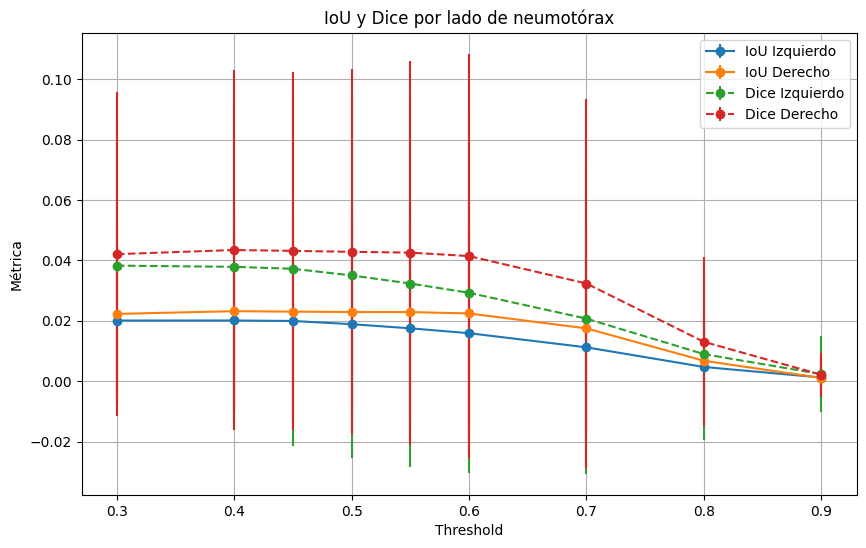

In [ ]:
plt.figure(figsize=(10, 6))

# IoU por lado
plt.errorbar(thresholds, iou_left, yerr=iou_left_std, fmt='-o', label='IoU Izquierdo')
plt.errorbar(thresholds, iou_right, yerr=iou_right_std, fmt='-o', label='IoU Derecho')

# Dice por lado
plt.errorbar(thresholds, dice_left, yerr=dice_left_std, fmt='--o', label='Dice Izquierdo')
plt.errorbar(thresholds, dice_right, yerr=dice_right_std, fmt='--o', label='Dice Derecho')

plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.title('IoU y Dice por lado de neumotórax')
plt.legend()
plt.grid(True)
plt.show()